## Data Exploration
### First,  import necessary packages and get data

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import style
import util
import get_data, sklearn
import datetime as dt
%matplotlib inline

style.use('ggplot')

# Choose start/end date, this will filter out the stock price data in the selected range

start_date = '1950-01-03'
end_date = '2017-4-21'
dates = pd.date_range(start_date, end_date)

# Choose which stock to look at
stock = '^GSPC'   # This S&P 500 index

data = get_data.get_data_csv(stock, dates, redownload=False) # If you already have downloaded data, you do not have to download it again
data.dropna(inplace=True) #drop anything NA

In [25]:
# All rights reserved by Hye Joo Han
# reference: https://github.com/math470/Springboard_Capstone_Project_1
# A function that draw a feature importance plot
def plot_feature_importances(model_name, importances, feature_names, num_features=None,
                             fig_size=None, ax=None):
    features_importances = pd.DataFrame(sorted(zip(feature_names, importances),
                                           key = lambda tup: tup[1], reverse=True),
                                   columns=['features','importances'])
    data = features_importances[:num_features]
    data.plot('features','importances', kind='barh', ax=ax,
              color='blue', figsize=fig_size, legend = None)
    plt.gca().invert_yaxis() # reverse the order of features
    plt.ylabel('feature importances')
    if num_features:
        plt.title(model_name + '\nTop '+str(num_features))
    else:
        plt.title(model_name + '\nAll Features')

### What is in the data for the first few lines?

In [26]:
data.head()

,Open,High,Low,Close,Volume,Adj Close
1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


### Removing any rows with same open/close prices.

In [27]:
data = util.remove_data_with_same_open_close(data)
data.head()

,Open,High,Low,Close,Volume,Adj Close
1962-01-02,71.550003,71.959999,70.709999,70.959999,3120000.0,70.959999
1962-01-03,70.959999,71.480003,70.379997,71.129997,3590000.0,71.129997
1962-01-04,71.129997,71.620003,70.449997,70.639999,4450000.0,70.639999
1962-01-05,70.639999,70.839996,69.349998,69.660004,4630000.0,69.660004
1962-01-08,69.660004,69.839996,68.169998,69.120003,4620000.0,69.120003


### Statistics of data

In [28]:
data[['Volume', 'Adj Close']].describe()

,Volume,Adj Close
count,1.383100e+04,13831.000000
mean,1.046133e+09,622.694092
std,1.606926e+09,612.513428
min,2.020000e+06,52.320000
25%,1.948000e+07,101.660004
50%,1.701400e+08,327.989990
75%,1.422950e+09,1141.619995
max,1.145623e+10,2395.959961


## Data Preprocessing

In [29]:
from mpl_finance import volume_overlay3
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import matplotlib.dates as mdates

In [30]:
def rolling_mean(df, length):
    return df.rolling(window=length, center=False).mean()

In [31]:
# calculate features
datanew = util.calc_features_new(data, look_back=240, fee=0)
AdjClose = data['Adj Close']
Volume = data['Volume']
datanew['120ma']=rolling_mean(AdjClose, 120).shift()
datanew['volume_120ma']=rolling_mean(Volume, 120).shift()
datanew.dropna(inplace=True)

# select features and target
target = datanew['Change']
features = datanew.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Change'], axis=1)

In [32]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

matplotlib.rc('font', **font)

## Exploratory Visualization

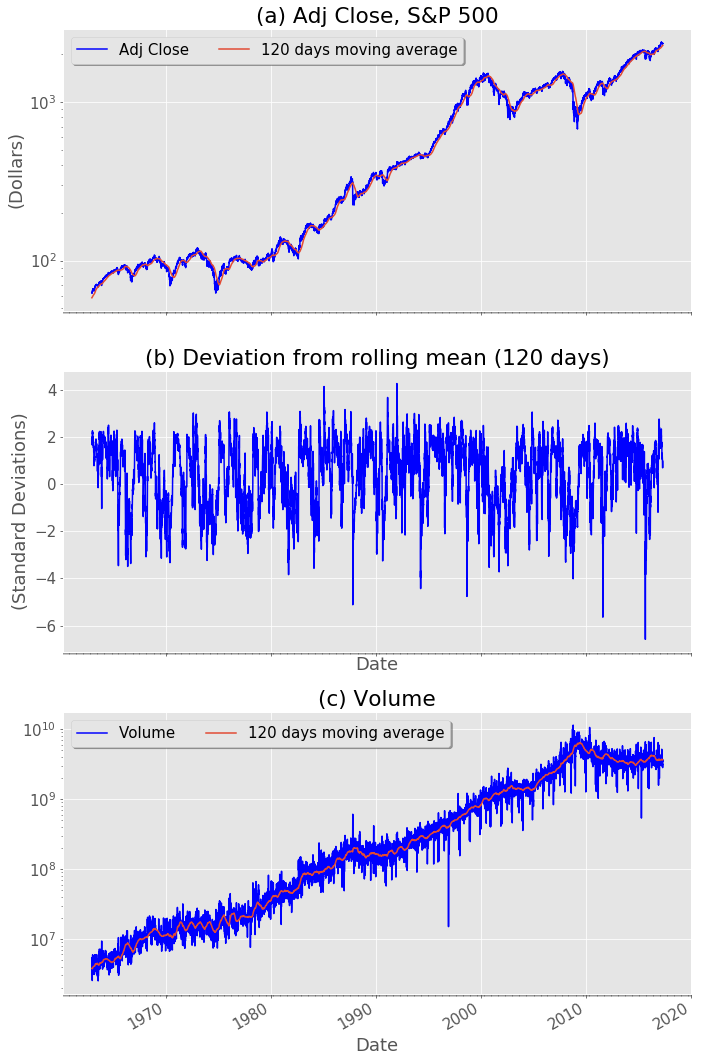

In [33]:
#Plot historical S&P 500 price
years = mdates.YearLocator(10)   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots(3, figsize=(10, 15), sharex=True)
ax[0].semilogy(datanew['Adj Close'], "b-", label='Adj Close')
ax[0].plot(datanew['120ma'], label='120 days moving average')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('(Dollars)')
ax[0].set_title('(a) Adj Close, S&P 500')
fig.autofmt_xdate()
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_major_formatter(yearsFmt)
ax[0].xaxis.set_minor_locator(months)
ax[0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)

#Plot deviation from mean
ax[1].plot(datanew['dev_120d'], "b-")
ax[1].set_xlabel('Date')
ax[1].set_ylabel('(Standard Deviations)')
ax[1].set_title('(b) Deviation from rolling mean (120 days)')

#Plot volume
ax[2].semilogy(datanew['Volume'], "b-", label='Volume')
ax[2].semilogy(datanew['volume_120ma'], label='120 days moving average')
ax[2].set_xlabel('Date')
#ax[2].set_ylabel('')
ax[2].set_title('(c) Volume')
ax[2].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()
fig.savefig('figures/sp500_120ma.png', dpi=300)

### Plot data only from 2000 to 2010

In [34]:
start_date = '2000-01-01'
end_date = '2010-12-31'
dates_partial = pd.date_range(start_date, end_date)

# Choose which stock to look at
stock = '^GSPC'

data_partial = get_data.get_data_csv(stock, dates_partial, redownload=False)
data_partial.dropna(inplace=True)

In [35]:
datanew_partial = util.calc_features_shift(data_partial, look_back=120, fee=0)
AdjClose = data_partial['Adj Close']
Volume = data_partial['Volume']
datanew_partial['120ma']=rolling_mean(AdjClose, 120).shift()
datanew_partial['volume_120ma']=rolling_mean(Volume, 120).shift()
datanew_partial.dropna(inplace=True)
target_partial = datanew_partial['Change']
#adjclose = datanew['Adj Close']
features_partial = datanew_partial.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Change'], axis=1)

In [36]:
features_partial

,Return1d,Return2d,Return3d,Return4d,Return5d,Return6d,Return20d,Return40d,Return60d,Return80d,Return100d,Return120d,dev_120d,120ma,volume_120ma
2000-06-23,0.000000,0.018558,0.016368,0.023289,0.008456,0.018283,-0.048658,0.008773,0.038797,-0.050262,-0.029542,0.002093,0.433042,1432.469498,1.032174e+09
2000-06-26,0.000000,0.007423,0.026119,0.023913,0.030885,0.015942,-0.044024,0.007596,0.032217,-0.041430,-0.022449,-0.029178,0.200655,1432.354998,1.031472e+09
2000-06-27,0.000000,-0.009503,-0.002151,0.016368,0.014182,0.021088,-0.022579,0.008892,0.029732,-0.031705,-0.020848,-0.036556,0.495119,1432.820748,1.030472e+09
2000-06-28,0.000000,0.003281,-0.006253,0.001124,0.019703,0.017511,-0.020647,-0.002937,0.038206,-0.040860,-0.018048,-0.032471,0.381941,1433.224415,1.030114e+09
2000-06-29,0.000000,-0.002935,0.000337,-0.009170,-0.001815,0.016710,-0.004131,-0.027302,0.027433,-0.068187,-0.021020,-0.009176,0.467056,1433.652498,1.030137e+09
2000-06-30,0.000000,0.008618,0.005657,0.008957,-0.000631,0.006787,0.024175,-0.022754,0.031184,-0.052475,-0.000465,0.010545,0.192616,1433.660165,1.029185e+09
2000-07-03,0.000000,-0.008394,0.000151,-0.002784,0.000488,-0.009020,0.008958,-0.015104,0.032133,-0.036374,-0.029486,-0.011027,0.462698,1433.635165,1.032476e+09
2000-07-05,0.000000,-0.010166,-0.018475,-0.010017,-0.012922,-0.009683,-0.007962,-0.030874,0.031853,-0.050676,-0.035868,-0.025375,0.784714,1433.893332,1.027791e+09
2000-07-06,0.000000,0.016118,0.005787,-0.002655,0.005940,0.002987,0.017376,-0.023572,0.040263,-0.043292,-0.040872,0.002386,0.268929,1434.009832,1.028164e+09
2000-07-07,0.000000,-0.007167,0.008835,-0.001421,-0.009803,-0.001270,0.003433,-0.050540,0.030151,-0.066947,-0.045810,0.005821,0.497131,1434.068082,1.027471e+09


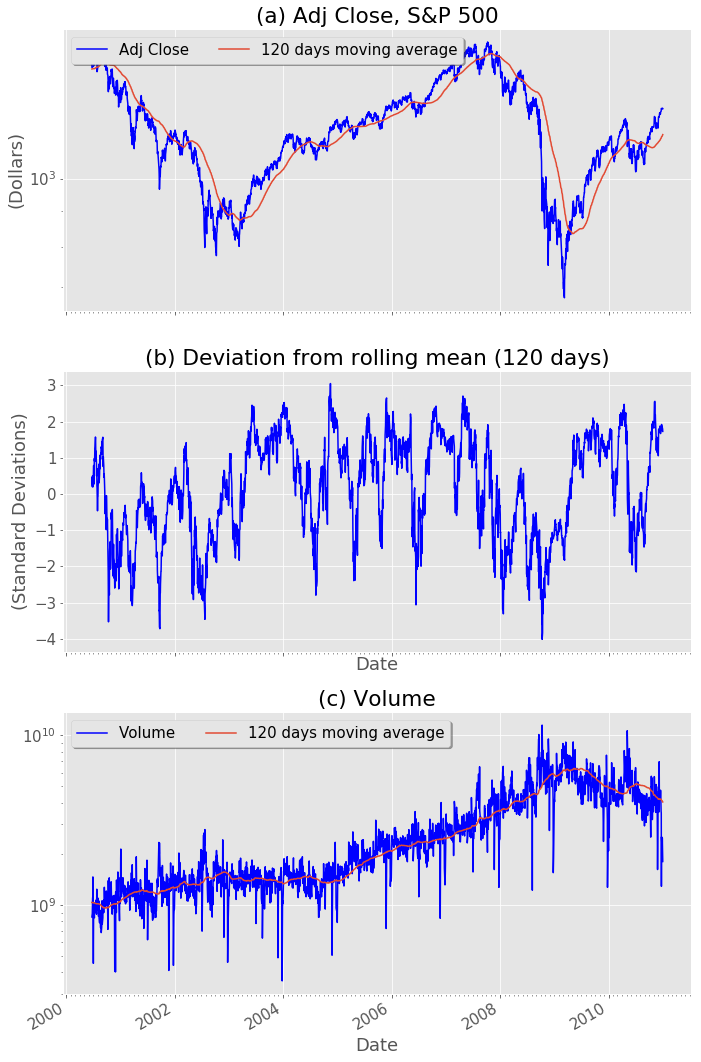

In [37]:
#plot S&P 500 price
years = mdates.YearLocator(1)   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots(3, figsize=(10, 15), sharex=True)
ax[0].semilogy(datanew_partial['Adj Close'], "b-", label='Adj Close')
ax[0].plot(datanew_partial['120ma'], label='120 days moving average')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('(Dollars)')
ax[0].set_title('(a) Adj Close, S&P 500')
fig.autofmt_xdate()
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_major_formatter(yearsFmt)
ax[0].xaxis.set_minor_locator(months)
ax[0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)

#plot deviation from mean
ax[1].plot(datanew_partial['dev_120d'],"b-")
ax[1].set_xlabel('Date')
ax[1].set_ylabel('(Standard Deviations)')
ax[1].set_title('(b) Deviation from rolling mean (120 days)')

#plot volume
ax[2].semilogy(datanew_partial['Volume'],"b-", label='Volume')
ax[2].semilogy(datanew_partial['volume_120ma'], label='120 days moving average')
ax[2].set_xlabel('Date')
#ax[2].set_ylabel('')
ax[2].set_title('(c) Volume')
ax[2].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)
plt.tight_layout()
plt.show()
fig.savefig('figures/sp500_120ma_2000-2010.png', dpi=300)

## Benchmark

In [38]:
import random
# function to plot ROI of benchmark
def benchmark_plot(data_test, fee=0):
    years = mdates.YearLocator(1)   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    #buy-hold
    nstock = 100
    start_asset = data_test.iloc[0]['Open'] * nstock
    buy_hold = start_asset + data_test['Close'] * nstock - data_test.iloc[0]['Open']*nstock
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(buy_hold / start_asset, label="buy-hold")
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    
    #random choice 0 vs 1
    price = data_test.iloc[0]['Open'] * nstock
    asset = np.zeros(len(data_test))
    asset[0] = price
    random.seed(1)    
    for i in range(len(data_test)):
        r = random.randint(0,1)
        if r == 1:
            price += -data_test.iloc[i]['Open'] * nstock + data_test.iloc[i]['Close'] * nstock - fee 
        else:
            #sell n stocks
            price += data_test.iloc[i]['Open'] * nstock - data_test.iloc[i]['Close'] * nstock - fee
        asset[i] = price    
    ax.plot(pd.DataFrame(asset, index=data_test.index) / start_asset, label="random")
    
    #always predict up
    price = data_test.iloc[0]['Open'] * nstock
    asset = np.zeros(len(data_test))
    asset[0] = price
    random.seed(1)    
    for i in range(len(data_test)):
        r = 1
        if r == 1:
            price += -data_test.iloc[i]['Open'] * nstock + data_test.iloc[i]['Close'] * nstock - fee 
        else:
            #sell n stocks
            price += data_test.iloc[i]['Open'] * nstock - data_test.iloc[i]['Close'] * nstock - fee
        asset[i] = price    
    ax.plot(pd.DataFrame(asset, index=data_test.index) / start_asset, label="always-up")

    #always predict down
    price = data_test.iloc[0]['Open'] * nstock
    asset = np.zeros(len(data_test))
    asset[0] = price
    random.seed(1)    
    for i in range(len(data_test)):
        r = 0
        if r == 1:
            price += -data_test.iloc[i]['Open'] * nstock + data_test.iloc[i]['Close'] * nstock - fee 
        else:
            #sell n stocks
            price += data_test.iloc[i]['Open'] * nstock - data_test.iloc[i]['Close'] * nstock - fee
        asset[i] = price    
    ax.plot(pd.DataFrame(asset, index=data_test.index) / start_asset, label="always-down")
    ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
    ax.set_xlabel('Date')
    ax.set_ylabel('Return on investment (normalized by initial value of stock)')
    plt.tight_layout()
    plt.show()
    fig.savefig('figures/benchmark.png', dpi=300)

In [39]:
#Train-test data splits for roll-forward cross validation
from sklearn import preprocessing
features_scaled = pd.DataFrame(preprocessing.scale(features))
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=15)
for train_index, test_index in tscv.split(features_scaled):
    X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
    y_train, y_test = target.values[train_index], target.values[test_index]

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by the scale function.
  app.launch_new_instance()
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [40]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = X_train, X_test, y_train, y_test
test_index_grid = test_index

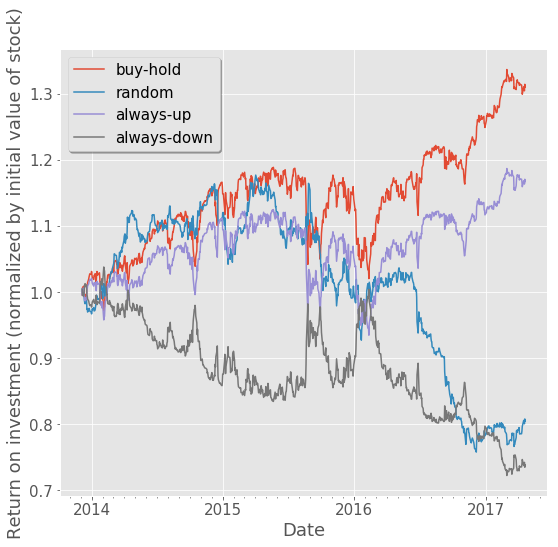

In [41]:
benchmark_plot(datanew.iloc[test_index], fee=10)

## Exploring Machine Learning Algorithms to predict stock market direction

In [42]:
# This function plots the ROI based on the prediction of machine learning algorithms
def gain_plot_from_test_data(data_test, y_pred, fee=0, model_name = ""):
    nstock = 100 #number of stocks to trade
    price = data_test.iloc[0]['Open'] * nstock
    asset = np.zeros(len(data_test))
    asset[0] = price
    
    #calculate ROI based on prediction
    for i in range(len(data_test)):
        if y_pred[i]>0.5:
            #buy n stocks
            price += -data_test.iloc[i]['Open'] * nstock + data_test.iloc[i]['Close'] * nstock - fee
        else:
            #sell n stocks
            price += data_test.iloc[i]['Open'] * nstock - data_test.iloc[i]['Close'] * nstock - fee
        asset[i] = price
    start_asset = data_test.iloc[0]['Open'] * nstock
    ref = start_asset + data_test['Close'] * nstock - data_test.iloc[0]['Open']*nstock
    
    #plot ROI
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(ref / start_asset, label='buy-hold')
    ax.plot(pd.DataFrame(asset, index=data_test.index) / start_asset, label=model_name)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
    ax.set_xlabel('Date')
    ax.set_ylabel('Return on investment')
    plt.tight_layout()
    plt.show()
    roi = asset[-1]/start_asset
    return roi

In [43]:
# train and test using roll forward cross validation scheme
def roll_forward_cross_validation(model, train_test_splits):
    # input
    #   model: the machine learning model used to train data
    #   train_test_splits: train and test splits using time series split scheme
    
    # output
    #   accuracy_list: the list of accuracy for the prediction made by the model in each split
    #   test_index: the index for the last testing
    #   y_pred: the prediction made by the model
    
    i = 1
    accuracy_list = []
    for train_index, test_index in train_test_splits:
        print('Split :', i)
        X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
        y_train, y_test = target.values[train_index], target.values[test_index]        
        model.train(X_train, y_train)
        y_pred = model.query(X_test)
        accuracy = util.accuracy(y_test,y_pred,type='accuracy_score')
        print('accuracy for split %d = %f' %( i, accuracy))
        accuracy_list.append(accuracy)
        i += 1
    return accuracy_list, test_index, y_pred

### Logistic Regression

Split : 1
accuracy for split 1 = 53.710247
Split : 2
accuracy for split 2 = 56.301531
Split : 3
accuracy for split 3 = 54.416961
Split : 4
accuracy for split 4 = 54.652532
Split : 5
accuracy for split 5 = 55.712603
Split : 6
accuracy for split 6 = 48.645465
Split : 7
accuracy for split 7 = 50.765607
Split : 8
accuracy for split 8 = 49.941107
Split : 9
accuracy for split 9 = 54.888104
Split : 10
accuracy for split 10 = 53.474676
Split : 11
accuracy for split 11 = 48.056537
Split : 12
accuracy for split 12 = 51.707892
Split : 13
accuracy for split 13 = 60.777385
Split : 14
accuracy for split 14 = 58.775029
Split : 15
accuracy for split 15 = 59.599529
average accuracy =  54.09501374165685


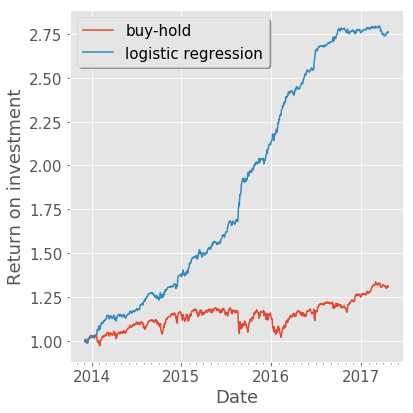

ROI =  2.759429870983982


In [44]:
# Import model API
from Model import Model
from sklearn.linear_model import LogisticRegression
model = Model(LogisticRegression(solver='liblinear'))

# Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(model, tscv.split(features_scaled))
    
# Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name = "logistic regression")
print('ROI = ', roi)

In [45]:
features_partial.columns

Index(['Return1d', 'Return2d', 'Return3d', 'Return4d', 'Return5d', 'Return6d',
       'Return20d', 'Return40d', 'Return60d', 'Return80d', 'Return100d',
       'Return120d', 'dev_120d', '120ma', 'volume_120ma'],
      dtype='object')

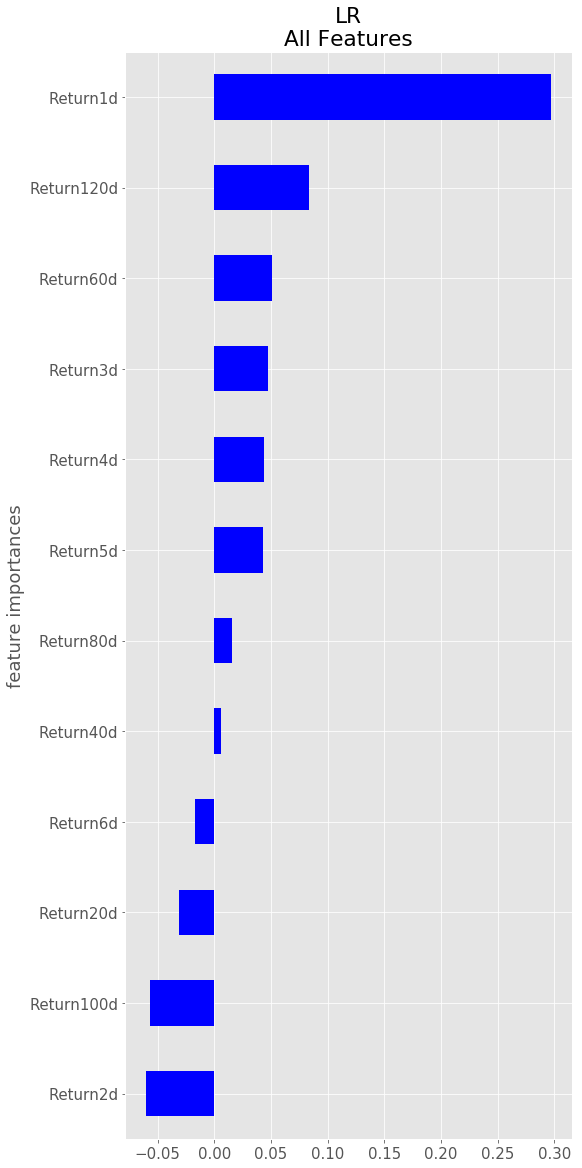

In [46]:
plot_feature_importances('LR', model.model.coef_[0], features_partial.columns, fig_size=[8,20])

### Gaussian Naive Bayes Algorithm

Split : 1
accuracy for split 1 = 48.527680
Split : 2
accuracy for split 2 = 52.414605
Split : 3
accuracy for split 3 = 53.710247
Split : 4
accuracy for split 4 = 53.592462
Split : 5
accuracy for split 5 = 54.770318
Split : 6
accuracy for split 6 = 52.179034
Split : 7
accuracy for split 7 = 54.652532
Split : 8
accuracy for split 8 = 51.707892
Split : 9
accuracy for split 9 = 55.477032
Split : 10
accuracy for split 10 = 53.239105
Split : 11
accuracy for split 11 = 51.001178
Split : 12
accuracy for split 12 = 44.640754
Split : 13
accuracy for split 13 = 56.890459
Split : 14
accuracy for split 14 = 55.241461
Split : 15
accuracy for split 15 = 53.239105
average accuracy =  52.75225755791127


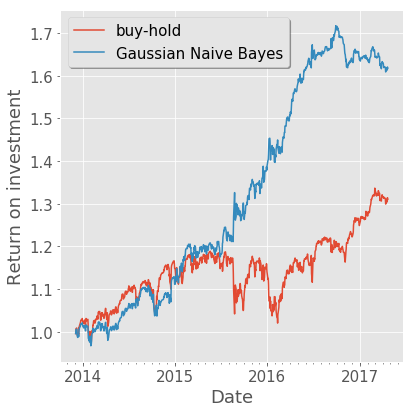

ROI =  1.6168703135152624


In [47]:
#Import model API
from sklearn.naive_bayes import GaussianNB
model = Model(GaussianNB())

#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(model, tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="Gaussian Naive Bayes")
print('ROI = ', roi)

### Decision Tree Algorithm

Split : 1
accuracy for split 1 = 51.118963
Split : 2
accuracy for split 2 = 51.943463
Split : 3
accuracy for split 3 = 54.181390
Split : 4
accuracy for split 4 = 53.239105
Split : 5
accuracy for split 5 = 54.888104
Split : 6
accuracy for split 6 = 52.061249
Split : 7
accuracy for split 7 = 50.176678
Split : 8
accuracy for split 8 = 44.994111
Split : 9
accuracy for split 9 = 52.767962
Split : 10
accuracy for split 10 = 47.938751
Split : 11
accuracy for split 11 = 54.181390
Split : 12
accuracy for split 12 = 54.888104
Split : 13
accuracy for split 13 = 48.881037
Split : 14
accuracy for split 14 = 56.065960
Split : 15
accuracy for split 15 = 53.356890
average accuracy =  52.04554377699254


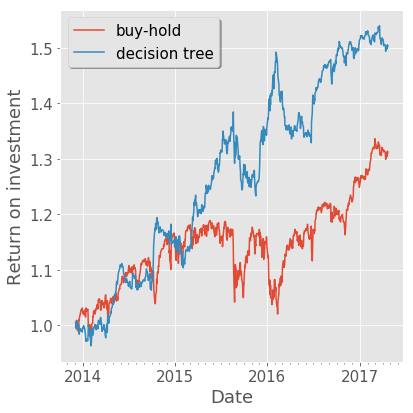

ROI =  1.502203525741958


In [48]:
#Import model API
from sklearn.tree import DecisionTreeClassifier
model = Model(DecisionTreeClassifier())

#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(model, tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="decision tree")
print("ROI = ", roi)

### Grid Search for Decision Tree Classifier

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#Parameters to search for
parameters = {'max_depth': list(range(1,10)),'min_samples_split':list(range(2,10,2)),'criterion':('gini','entropy'),'splitter':('best','random')}

model=DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(model, parameters, cv=list(tscv.split(X_train_grid)))
grid.fit(X_train_grid,y_train_grid)

#save model for later use
decision_tree_best_model = Model(grid.best_estimator_)

#print out what is the best model parameters
print(grid.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


### Playback the best decision tree algorithm found by grid search

Split : 1
accuracy for split 1 = 51.943463
Split : 2
accuracy for split 2 = 54.652532
Split : 3
accuracy for split 3 = 54.299176
Split : 4
accuracy for split 4 = 56.419317
Split : 5
accuracy for split 5 = 54.534747
Split : 6
accuracy for split 6 = 52.767962
Split : 7
accuracy for split 7 = 56.301531
Split : 8
accuracy for split 8 = 52.885748
Split : 9
accuracy for split 9 = 56.890459
Split : 10
accuracy for split 10 = 53.239105
Split : 11
accuracy for split 11 = 48.292108
Split : 12
accuracy for split 12 = 54.888104
Split : 13
accuracy for split 13 = 62.661955
Split : 14
accuracy for split 14 = 62.779741
Split : 15
accuracy for split 15 = 63.015312
average accuracy =  55.70475068708284


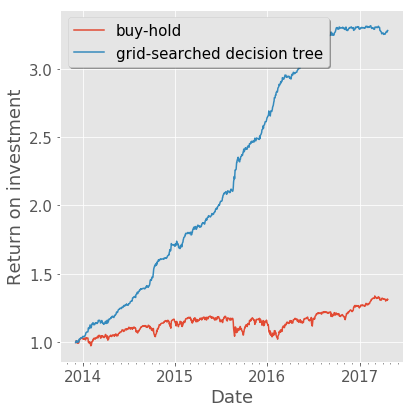

ROI =  3.2786904223600803


In [50]:
#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(decision_tree_best_model,\
                                                                  tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="grid-searched decision tree")
print("ROI = ", roi)

### Support Vector Machine Classifier

Split : 1
accuracy for split 1 = 51.943463
Split : 2


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 2 = 56.537102
Split : 3


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 3 = 53.356890
Split : 4


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 4 = 56.419317
Split : 5


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 5 = 53.710247
Split : 6


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 6 = 51.472320
Split : 7


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 7 = 53.592462
Split : 8


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 8 = 50.883392
Split : 9


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 9 = 56.419317
Split : 10


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 10 = 54.181390
Split : 11


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 11 = 47.585395
Split : 12


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 12 = 53.474676
Split : 13


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 13 = 56.183746
Split : 14


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 14 = 57.714959
Split : 15


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 15 = 61.248528
average accuracy =  54.314880251276016


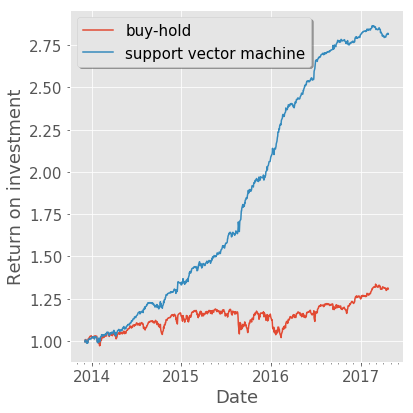

ROI =  2.8170589729635105


In [51]:
from sklearn.svm import SVC
model = Model(SVC())

#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(model,\
                                                                  tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="support vector machine")
print("ROI = ", roi)

### Grid search for Support Vector Machine Classifier

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#Parameters to search for
parameters = {'C': (0.1, 1, 10),'kernel':('poly','rbf')}

model=SVC(random_state=1)
grid = GridSearchCV(model, parameters, cv=list(tscv.split(X_train_grid)))
grid.fit(X_train_grid,y_train_grid)

#save the model for later use
svm_best_model = Model(grid.best_estimator_)

#print out the best model parameters
print(grid.best_estimator_)

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packa

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packa

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packa

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packa

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False)


### Playback the best support vector classifier found by grid search

Split : 1
accuracy for split 1 = 51.354535
Split : 2
accuracy for split 2 = 53.945819
Split : 3


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 3 = 53.356890
Split : 4


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 4 = 54.181390
Split : 5


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 5 = 56.419317
Split : 6


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 6 = 53.710247
Split : 7


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 7 = 55.712603
Split : 8


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 8 = 52.650177
Split : 9


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 9 = 56.537102
Split : 10


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 10 = 53.239105
Split : 11


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 11 = 48.056537
Split : 12


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 12 = 55.359246
Split : 13


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 13 = 60.070671
Split : 14


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 14 = 59.599529
Split : 15


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy for split 15 = 61.012956
average accuracy =  55.0137416568512


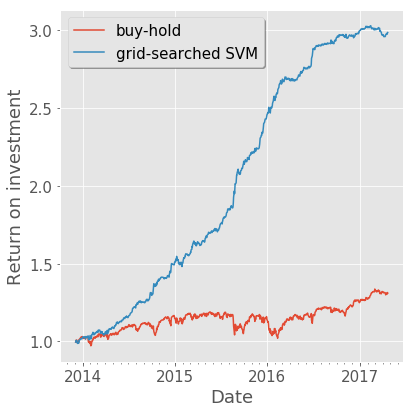

ROI =  2.9851425033164176


In [53]:
#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(svm_best_model,\
                                                                  tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="grid-searched SVM")
print("ROI = ", roi)

### Random forest classifer

Split : 1
accuracy for split 1 = 48.409894
Split : 2
accuracy for split 2 = 55.359246
Split : 3
accuracy for split 3 = 54.299176
Split : 4
accuracy for split 4 = 51.825677
Split : 5
accuracy for split 5 = 51.472320
Split : 6
accuracy for split 6 = 50.765607
Split : 7
accuracy for split 7 = 54.652532
Split : 8
accuracy for split 8 = 55.005889
Split : 9
accuracy for split 9 = 57.479388
Split : 10
accuracy for split 10 = 52.532391
Split : 11
accuracy for split 11 = 50.412250
Split : 12
accuracy for split 12 = 54.888104
Split : 13
accuracy for split 13 = 56.065960
Split : 14
accuracy for split 14 = 59.128386
Split : 15
accuracy for split 15 = 59.128386
average accuracy =  54.09501374165686


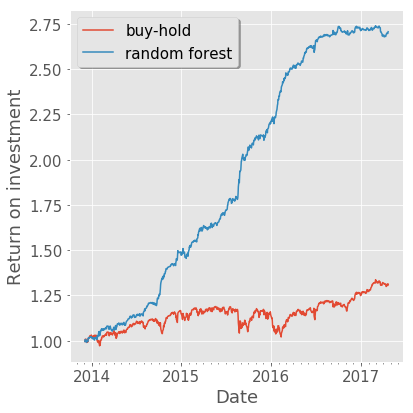

ROI =  2.705937686413381


In [54]:
#Import model API
from sklearn.ensemble import RandomForestClassifier
model = Model(RandomForestClassifier(3, max_depth=5, random_state=1))

#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(model,\
                                                                  tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="random forest")
print("ROI = ", roi)

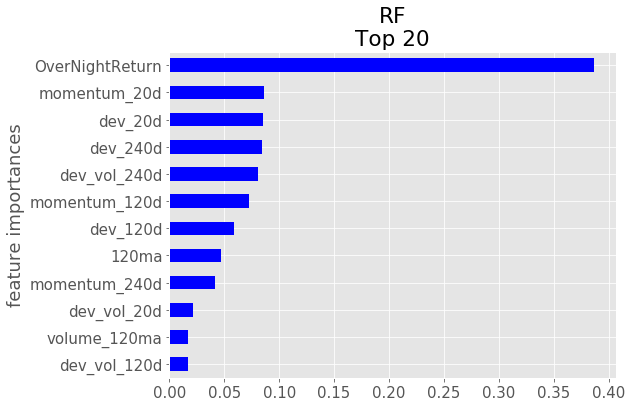

In [55]:
plot_feature_importances("RF", model.model.feature_importances_, features.columns, num_features = 20, fig_size=[8,6])

### Grid search for random forest

In [56]:
# Parameters to search for
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# import packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model=RandomForestClassifier(n_estimators=20)
grid = GridSearchCV(model, param_grid=param_grid, cv=list(tscv.split(X_train_grid)))
grid.fit(X_train_grid,y_train_grid)

# save the model for later use
random_forest_best_model = Model(grid.best_estimator_)

# print out the best model parameters
print(grid.best_estimator_)

ImportError: No module named 'sklearn.grid_search'

### Playback the best random forest algorithm found by grid search

In [ ]:
#Cross-validation using roll-forward scheme
accuracy_list, test_index, y_pred = roll_forward_cross_validation(random_forest_best_model,\
                                                                  tscv.split(features_scaled))
    
#Average accuracy?
print('average accuracy = ', np.mean(accuracy_list))
    
# Plot the gain for the testing data
roi = gain_plot_from_test_data(datanew.iloc[test_index], y_pred, fee=10, model_name="grid-searched random forest")
print("ROI = ", roi)

## Neural network algorithm

### prepare the target data with one-hot encoding

In [51]:
import tensorflow as tf

In [52]:
target = pd.DataFrame(target)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
one_hot.fit(target)
target_scaled = one_hot.transform(target).toarray()

### Utility functions that are used for neural network training/testing and plotting

In [62]:
# a function that plots return on investment from neural network's prediction for the testing period
def gain_plot_from_test_data_neural_network(y_pred, test_index, fee=0, label='', filename=None):
    data_test = datanew.iloc[test_index]
    asset = np.zeros(len(data_test))
    nstock=100
    price = data_test.iloc[0]['Open'] * nstock
    # initial asset price
    asset[0] = price
    for i in range(len(data_test)):
        if y_pred[i][0] < y_pred[i][1]:
            #buy n stocks
            price += -data_test.iloc[i]['Open'] * nstock + data_test.iloc[i]['Close'] * nstock - fee
        else:
            #sell n stocks
            price += data_test.iloc[i]['Open'] * nstock - data_test.iloc[i]['Close'] * nstock - fee
        asset[i] = price # the asset price each day
    start_asset = data_test.iloc[0]['Open'] * nstock
    # This is reference buy-hold strategy
    ref = start_asset + data_test['Close'] * nstock - data_test.iloc[0]['Open']*nstock
    roi = asset[-1]/start_asset
    
    #plot ROI
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(ref / start_asset, label='buy-hold (benchmark)')
    ax.plot(pd.DataFrame(asset, index=data_test.index) / start_asset, label=label)
    
    #axis
    years = mdates.YearLocator(1)   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    
    #legend and label
    ax.legend(loc="upper left", fontsize=14,
           ncol=1, shadow=True, fancybox=True)
    ax.set_xlabel('Date')
    ax.set_ylabel('Return on investment')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
        
    plt.tight_layout()
    plt.show()
    
    #save to file
    if filename != None:
        fig.savefig(filename, dpi=300)
    return roi, ax

In [65]:
# This is a function to train/test 1 hidden layer neural network
def neuralnetwork_1hiddenlayer(sess, h1n, learning_rate = 0.001, training_epochs=10000, keep_prob=1.0):
    #input
    #  sess: the tensorflow session
    #  h1n: the number of neurons in the hidden layer
    #  learning_rate: learning rate 
    #  training_epochs: total number of training iteration
    #  keep_prob: keep probability of drop-out
    
    #output
    #  nnmodel: neural network model instance
    #  y_pred_list: the predicted probability for stock market increase/decrease for all the splits
    #  y_test: the test data for the last split
    #  test_index: the index for the testing data in the last split
    #  accuracy_list: the accuracy for the splits
    #  cost_list: the cost or loss for training splits
    #  test_cost_list: the cost or loss for testing splits
       
    i = 1
    accuracy_list = []
    test_cost_list = []
    cost_list = []
    y_pred_list = []
    
    #roll-forward cross validation
    for train_index, test_index in tscv.split(features_scaled):
        i += 1
        X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
        y_train, y_test = target_scaled[train_index], target_scaled[test_index]
        
        # create neural network instance
        nnmodel = NeuralNetwork(sess, X_train.shape[0], X_train.shape[1], n_nodes=[h1n],\
                                actf=[tf.nn.sigmoid], dropout = [False],\
                                learning_rate=learning_rate, training_epochs=training_epochs)
        
        #train and test
        y_pred, cost, test_cost = nnmodel.train_and_test(X_train, y_train, X_test, y_test, keep_prob)
        cost_list.append(cost)
        test_cost_list.append(test_cost)
        
        #calculate accuracy
        correct_prediction = np.equal(np.argmax(y_test,1), np.argmax(y_pred,1))
        accuracy = np.mean(correct_prediction.astype(np.float32))
        accuracy_list.append(accuracy)
        y_pred_list.append(y_pred)
        
    print('\nmean test accuracy = ', np.mean(accuracy_list))   
    
    return (nnmodel, y_pred_list, y_test, test_index, accuracy_list, cost_list, test_cost_list)

In [58]:
from NeuralNetwork_Cross_Entropy_mini_batch import NeuralNetwork

### Initial neural network algorithm with 40 neurons and 1 hidden layer

epoch = 2900, cost = 0.493531, test_cost = 1.032374
mean test accuracy =  0.528816


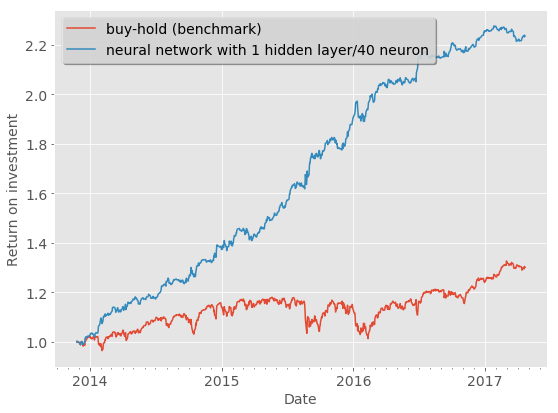

2.23512298568


In [66]:
with tf.Session() as sess:
    (nnmodel, y_pred_list, y_test, test_index, accuracy_list, cost_list, test_cost_list) = \
                    neuralnetwork_1hiddenlayer(sess, 40, learning_rate = 0.001, training_epochs=3000, keep_prob=0.5)
        
roi, ax = gain_plot_from_test_data_neural_network(y_pred_list[-1], test_index, fee=10,\
                                        label='neural network with 1 hidden layer/40 neuron')
print(roi)

## Hyper parameter optimization

### 1 hidden layer

In [68]:
accuracy_dict = {} #average accuracy for all the splits
accuracy_list_dict = {} #accuracy list
cost_dict = {} #training cost
test_cost_dict = {} #testing cost
best_prediction = 0

#parameter search
#  h1n: number of neurons in the first hidden layer
#  keep_prob: the keep probability for drop-out
#  learning_rate: the learning rate for gradient descent algorithm

for h1n in [1, 2, 4, 8, 16, 32]:
    if h1n == 1:
        keep_prob_list = [1.0]
    else:
        keep_prob_list = [1.0, 0.5]
    for keep_prob in keep_prob_list:
        for learning_rate in [0.001, 0.0001]:
            print("learning_rate = " + str(learning_rate))
            print("#1st hidden_layer_size = " + str(h1n)\
                + ", keep_prob = " + str(keep_prob))
            index = 'learning_rate_'+str(learning_rate)+'_h1n_'+str(h1n)+'_kp_'+str(keep_prob)
            with tf.Session() as sess:            
                # train and test neural network
                (nnmodel, y_pred_list, y_test, test_index, accuracy_list, cost_list, test_cost_list) = \
                    neuralnetwork_1hiddenlayer(sess, h1n, learning_rate = 0.001, training_epochs=3000,\
                                               keep_prob=keep_prob)                
            accuracy_dict[index] = np.mean(accuracy_list)
            accuracy_list_dict[index] = accuracy_list
            cost_dict[index] = cost_list
            test_cost_dict[index] = test_cost_list
            print('\ntest accuracy = ', accuracy_dict[index])
            
            #save the best prediction if the current accuracy is larger than best_prediction
            if accuracy_dict[index] > best_prediction:
                best_prediction = accuracy_dict[index]
                best_nn_estimator = nnmodel
                best_index = index
                best_pred_list = y_pred_list
                best_pred = best_pred_list[-1]
                save_test = y_test
                save_test_index = test_index

learning_rate = 0.001
#1st hidden_layer_size = 1, keep_prob = 1.0
epoch = 2900, cost = 0.675668, test_cost = 0.655814
mean test accuracy =  0.560436

test accuracy =  0.560436
learning_rate = 0.0001
#1st hidden_layer_size = 1, keep_prob = 1.0
epoch = 2900, cost = 0.675668, test_cost = 0.655815
mean test accuracy =  0.560592

test accuracy =  0.560592
learning_rate = 0.001
#1st hidden_layer_size = 2, keep_prob = 1.0
epoch = 2900, cost = 0.671433, test_cost = 0.651959
mean test accuracy =  0.551636

test accuracy =  0.551636
learning_rate = 0.0001
#1st hidden_layer_size = 2, keep_prob = 1.0
epoch = 2900, cost = 0.669456, test_cost = 0.662534
mean test accuracy =  0.55553

test accuracy =  0.55553
learning_rate = 0.001
#1st hidden_layer_size = 2, keep_prob = 0.5
epoch = 2900, cost = 0.670708, test_cost = 0.673616
mean test accuracy =  0.548676

test accuracy =  0.548676
learning_rate = 0.0001
#1st hidden_layer_size = 2, keep_prob = 0.5
epoch = 2900, cost = 0.669935, test_cost = 0.660280
m

In [69]:
# print out testing dates
testing_dates = []
for train_index, test_index in tscv.split(datanew):
    testing_dates.append([datanew.index[test_index][0], datanew.index[test_index][-1]])
testing_dates

[[Timestamp('1966-01-11 00:00:00'), Timestamp('1969-08-07 00:00:00')],
 [Timestamp('1969-08-08 00:00:00'), Timestamp('1973-01-30 00:00:00')],
 [Timestamp('1973-01-31 00:00:00'), Timestamp('1976-06-28 00:00:00')],
 [Timestamp('1976-06-29 00:00:00'), Timestamp('1979-11-29 00:00:00')],
 [Timestamp('1979-11-30 00:00:00'), Timestamp('1983-04-21 00:00:00')],
 [Timestamp('1983-04-22 00:00:00'), Timestamp('1986-09-15 00:00:00')],
 [Timestamp('1986-09-16 00:00:00'), Timestamp('1990-02-06 00:00:00')],
 [Timestamp('1990-02-07 00:00:00'), Timestamp('1993-06-28 00:00:00')],
 [Timestamp('1993-06-29 00:00:00'), Timestamp('1996-11-15 00:00:00')],
 [Timestamp('1996-11-18 00:00:00'), Timestamp('2000-04-11 00:00:00')],
 [Timestamp('2000-04-12 00:00:00'), Timestamp('2003-09-10 00:00:00')],
 [Timestamp('2003-09-11 00:00:00'), Timestamp('2007-02-06 00:00:00')],
 [Timestamp('2007-02-07 00:00:00'), Timestamp('2010-06-30 00:00:00')],
 [Timestamp('2010-07-01 00:00:00'), Timestamp('2013-11-22 00:00:00')],
 [Time

In [71]:
print(best_index)
print(accuracy_list_dict[best_index])

learning_rate_0.0001_h1n_1_kp_1.0
[0.54789722, 0.60514021, 0.60280377, 0.5537383, 0.56074768, 0.52686918, 0.56542057, 0.52219623, 0.56425232, 0.51635516, 0.49883178, 0.46845794, 0.61799067, 0.625, 0.63317758]


## Free fom plots

In [73]:
# function that plots training/testing cost vs iteration in gradient descent algorithm of neural network
def cost_plot(training_cost, test_cost, filename=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(training_cost, label = 'training cost')
    ax.plot(test_cost, label = 'testing cost')
    ax.legend(loc="upper right", 
             ncol=1, shadow=True, fancybox=True)
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('cost')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    plt.tight_layout()
    plt.show()
    if filename != None:
        fig.savefig(filename, dpi=300)

### Traing/testing cost  for 1 neuron vs 2 neuron networks

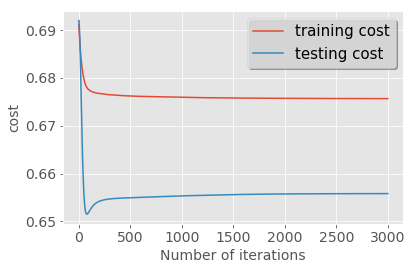

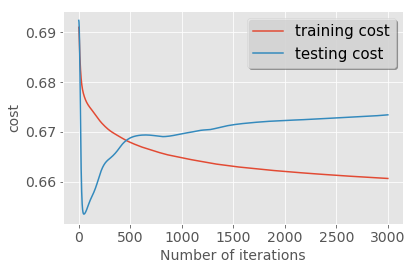

In [86]:
# plot the training/testing cost of the best model 1 neurons in the hidden layer
cost_plot(cost_dict[best_index][-1], test_cost_dict[best_index][-1],\
          filename='figures/cost_nn_1_1.png')

# plot the training/testing cost of the neural network with 4 neurons in the hidden layer
cost_plot(cost_dict['learning_rate_0.001_h1n_4_kp_1.0'][-1],\
          test_cost_dict['learning_rate_0.001_h1n_4_kp_1.0'][-1],\
          filename='figures/cost_nn_1_4.png')

### Testing accuracy for 1 neuron vs 4 neuron networks

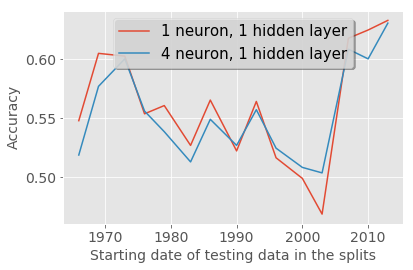

In [87]:
# get the starting date for each testing split
testing_date_start = []
for train_index, test_index in tscv.split(datanew):
    testing_date_start.append(datanew.index[test_index][0].year)
index = 'learning_rate_0.001_h1n_4_kp_1.0'
fig, ax = plt.subplots(figsize=(6, 4))

#plot accuracy of 1 neuron model vs 4 neuron model
ax.plot(testing_date_start, accuracy_list_dict[best_index], label = '1 neuron, 1 hidden layer')
ax.plot(testing_date_start, accuracy_list_dict[index], label = '4 neuron, 1 hidden layer')
ax.legend(loc="upper center", 
         ncol=1, shadow=True, fancybox=True)
ax.set_xlabel('Starting date of testing data in the splits')
ax.set_ylabel('Accuracy')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.tight_layout()
plt.show()
fig.savefig('figures/accuracy_nn_comparison.png', dpi=300)

### ROI for different testing splits for the best model (1 neuron/1 hidden layer)

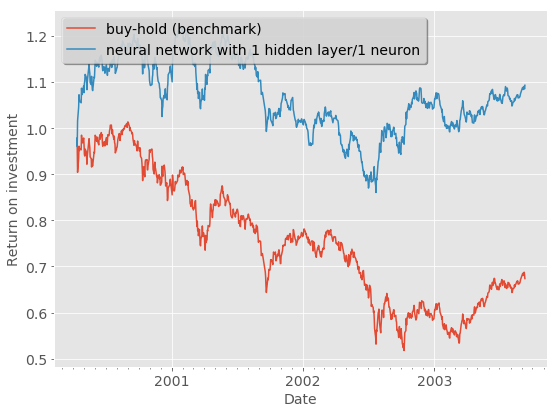

1.09283590691


In [88]:
y_pred = best_pred_list[10]
train_index, test_index = list(tscv.split(features_scaled))[10]

#Plot ROI
roi, ax = gain_plot_from_test_data_neural_network(y_pred, test_index, fee=10,\
                                        label='neural network with 1 hidden layer/1 neuron',\
                                        filename = 'figures/roi_nn_1_1_2000.png')
print('ROI=', roi)

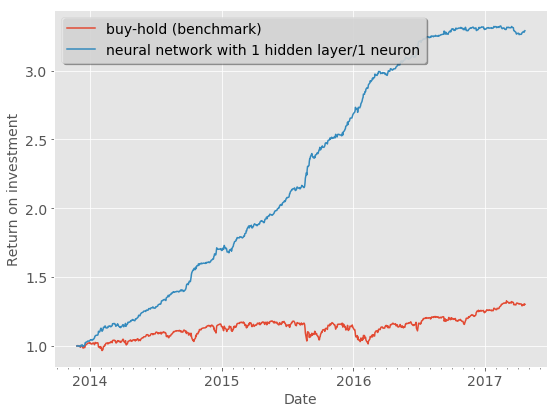

accuracy =  0.560592
ROI= 3.28976001616


In [90]:
y_pred = best_pred_list[-1]
train_index, test_index = list(tscv.split(features_scaled))[-1]

#Plot ROI
roi, ax = gain_plot_from_test_data_neural_network(y_pred, test_index, fee=10,\
                                        label='neural network with 1 hidden layer/1 neuron',\
                                        filename = 'figures/roi_nn_1_1.png')
print('accuracy = ', accuracy_dict[best_index])
print('ROI=', roi)